# Creating new dataset seperately with bbox and regression

In [248]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import h5py
import numpy as np
import os 
import PIL.Image as Image
from PIL import Image, ImageDraw
import math
import pprint as pp
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import os
import sys
import tensorflow as tf
import idx2numpy
import numpy as np
import random
from PIL import Image
import math
import h5py
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
train_folder='./train/'
test_folder='./test/'
extra_folder='./extra/'

In [3]:
#bounding box extraction

def extract_boundingbox(mat_file):
    '''
    ## input: hdf5 mat file
    ## output format

    [{'boxes': [{'width': 19.0, 'top': 7.0, 'height': 30.0, 'label': 5.0, 'left': 43.0}], 'filename': '1.png'}, 
     {'boxes': [{'width': 14.0, 'top': 5.0, 'height': 23.0, 'label': 2.0, 'left': 99.0}, 
                {'width': 12.0, 'top': 6.0, 'height': 23.0, 'label': 10.0, 'left': 121.0}], 'filename': '2.png'}]
    '''

    f=h5py.File(mat_file, 'r')

    digitStructName = f['digitStruct']['name']
    digitStructBbox = f['digitStruct']['bbox']
    bbox = {}
    result=[]
    item={}

    for n in np.arange(0,len(digitStructName)): ## iterate every file
        
        if (len(f[digitStructBbox[n].item()]["height"]) > 1):
            bbox['top'] = [f[f[digitStructBbox[n].item()]["top"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["top"]))]
            bbox['left'] = [f[f[digitStructBbox[n].item()]["left"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["left"]))]
            bbox['height'] = [f[f[digitStructBbox[n].item()]["height"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["height"]))]
            bbox['width'] = [f[f[digitStructBbox[n].item()]["width"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["width"]))]
            bbox['label'] = [f[f[digitStructBbox[n].item()]["label"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["label"]))]   
        else:
            bbox['top'] = [f[digitStructBbox[n].item()]["top"].value[0][0]]
            bbox['left'] = [f[digitStructBbox[n].item()]["left"].value[0][0]]
            bbox['height'] = [f[digitStructBbox[n].item()]["height"].value[0][0]]
            bbox['width'] = [f[digitStructBbox[n].item()]["width"].value[0][0]]
            bbox['label'] = [f[digitStructBbox[n].item()]["label"].value[0][0]]

        item={'filename':''.join([chr(c[0]) for c in f[digitStructName[n][0]].value])}
        figures = []   
        for i in range(len(f[digitStructBbox[n].item()]["height"])):
            figure={}
            figure['top']=bbox['top'][i]
            figure['left']=bbox['left'][i]
            figure['height']=bbox['height'][i]
            figure['width']=bbox['width'][i]
            figure['label']=bbox['label'][i]
            figures.append(figure)
        item['boxes'] = figures
        result.append(item)
    
    return result

In [4]:
#extract bbox and filename from all dataset "test_bboxdata"

test_bboxdata=extract_boundingbox('./test/digitStruct.mat')
train_data=extract_boundingbox('./train/digitStruct.mat')
extra_data=extract_boundingbox('./extra/digitStruct.mat')


In [5]:
train_bboxdata=train_data
extra_bboxdata=extra_data

In [6]:
print(len(test_bboxdata))
print(len(train_bboxdata))
print(len(extra_bboxdata))

13068
33402
202353


In [7]:
def openPng_crop_saveBbox(bboxdata, folder): 
    #input:bounding box and label
    #output:cropped image and label

    newdataset = np.ndarray([len(bboxdata),32,32,1], dtype='float32')
    ratioed_bboxes=np.ndarray([len(bboxdata),22], dtype='float32')
    labels = np.ones([len(bboxdata),6], dtype=int) * 10
   
    
    for i in np.arange(len(bboxdata)): #len(bboxdata)
        
        #restore bbox info
        boxes = bboxdata[i]['boxes']
        num_digit = len(boxes) 
        
        #Open png file with filename
        filename = bboxdata[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        png_width,png_height=im.size

        top = np.ndarray([num_digit],dtype='float32') 
        left = np.ndarray([num_digit],dtype='float32')
        height = np.ndarray([num_digit],dtype='float32')
        width = np.ndarray([num_digit],dtype='float32')
        labels[i,0] = num_digit

        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: 
                    labels[i,j+1] = 0
            elif num_digit > 5: print('Index',i,'th image(',filename, ') has ',num_digit,'digits.')

            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']


        ################################################################# 
        #creating ratioed bbox data for bbox to feed regression and prediction
        top_ratio=top/png_height
        left_ratio=left/png_width
        height_ratio=height/png_height
        width_ratio=width/png_width

        if num_digit<=5: 
            
            emptybox=np.zeros([5-num_digit])
            top_ratio_array=np.concatenate((emptybox,top_ratio))
            left_ratio_array=np.concatenate((emptybox,left_ratio))
            height_ratio_array=np.concatenate((emptybox,height_ratio))
            width_ratio_array=np.concatenate((emptybox,width_ratio))
        
            ratioed_bbox=np.concatenate((top_ratio_array,left_ratio_array,height_ratio_array,width_ratio_array))
            ratioed_bboxes[i,:]=ratioed_bbox
            
        elif num_digit>5: 
            
            ratioed_bbox=np.zeros([20])
            ratioed_bboxes[i,:]=ratioed_bbox
            
        #################################################################

        # bounding box information of area encompassing all digits
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left

        # resize bounding box and create points to crop 
        im_top = np.floor(1.0*im_top - 0.1 * im_height)
        im_left = np.floor(1.0*im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(1.0*im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(1.0*im_left + 1.2 * im_width), im.size[0]])

        # crop, make grey scale
        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        im=np.asarray(im, dtype="float32" )
        newdataset[i,:,:,:] = im[:,:,:]
            

    return ratioed_bboxes, newdataset, labels

# regression only first


In [20]:
def openPng_saveBbox_downsample_crop(bboxdata, folder): 
    #input:bounding box and label
    #output:cropped image and label

    downsampled_dataset = np.ndarray([len(bboxdata),32,32,1], dtype='float32')
    cropped_dataset = np.ndarray([len(bboxdata),32,32,1], dtype='float32')
    ratioed_bboxes=np.ndarray([len(bboxdata),20], dtype='float32')
    labels = np.ones([len(bboxdata),6], dtype=int) * 10
   
    
    for i in np.arange(len(bboxdata)): #len(bboxdata)
        
        #restore bbox info
        boxes = bboxdata[i]['boxes']
        num_digit = len(boxes) 
        
        #Open png file with filename
        filename = bboxdata[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        png_width,png_height=im.size

        top = np.ndarray([num_digit],dtype='float32') 
        left = np.ndarray([num_digit],dtype='float32')
        height = np.ndarray([num_digit],dtype='float32')
        width = np.ndarray([num_digit],dtype='float32')
        labels[i,0] = num_digit

        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: 
                    labels[i,j+1] = 0
            elif num_digit > 5: print('Index',i,'th image(',filename, ') has ',num_digit,'digits.')

            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']


        ################################################################# 
        #creating ratioed bbox data for bbox to feed regression and prediction
        top_ratio=top/png_height
        left_ratio=left/png_width
        height_ratio=height/png_height
        width_ratio=width/png_width

        if num_digit<=5: 
            
            emptybox=np.zeros([5-num_digit])
            top_ratio_array=np.concatenate((emptybox,top_ratio))
            left_ratio_array=np.concatenate((emptybox,left_ratio))
            height_ratio_array=np.concatenate((emptybox,height_ratio))
            width_ratio_array=np.concatenate((emptybox,width_ratio))
        
            ratioed_bbox=np.concatenate((top_ratio_array,left_ratio_array,height_ratio_array,width_ratio_array))
            ratioed_bboxes[i,:]=ratioed_bbox
            
        elif num_digit>5: 
            
            ratioed_bbox=np.zeros([20])
            ratioed_bboxes[i,:]=ratioed_bbox
            
        #################################################################

        # bounding box information of area encompassing all digits
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left

        # resize bounding box and create points to crop 
        im_top = np.floor(1.0*im_top - 0.1 * im_height)
        im_left = np.floor(1.0*im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(1.0*im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(1.0*im_left + 1.2 * im_width), im.size[0]])

        #downsample raw image
        im_downsampled=im.resize([32,32],Image.LANCZOS)
        im_downsampled = np.dot(np.array(im_downsampled, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        downsampled_dataset[i,:,:,:] = im_downsampled[:,:,:]
        
        # crop, make grey scale
        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.LANCZOS) # Image.ANTIALIAS
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        im=np.asarray(im, dtype="float32" )
        cropped_dataset[i,:,:,:] = im[:,:,:]
        
            
    return ratioed_bboxes, downsampled_dataset, cropped_dataset, labels

In [21]:
train_ratioed_bboxes, train_dataset_raw, train_dataset, train_labels = openPng_saveBbox_downsample_crop(train_bboxdata,train_folder)

print('trainset ratioed_bboxes=',train_ratioed_bboxes.shape)
print('trainset train_dataset_raw=',train_dataset_raw.shape)
print('trainset train_dataset=',train_dataset.shape)
print('trainset train_label=',train_labels.shape)

Index 29929 th image( 29930.png ) has  6 digits.
trainset ratioed_bboxes= (33402, 20)
trainset train_dataset_raw= (33402, 32, 32, 1)
trainset train_dataset= (33402, 32, 32, 1)
trainset train_label= (33402, 6)


In [22]:
#Delete any data with more than 5 digits
train_dataset_raw = np.delete(train_dataset_raw, 29929, axis=0)
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)
train_ratioed_bboxes = np.delete(train_ratioed_bboxes, 29929, axis=0)

print('trainset ratioed_bboxes=',train_ratioed_bboxes.shape)
print('trainset train_dataset_raw=',train_dataset_raw.shape)
print('trainset train_dataset=',train_dataset.shape)
print('trainset train_labels=',train_labels.shape)

trainset ratioed_bboxes= (33401, 20)
trainset train_dataset_raw= (33401, 32, 32, 1)
trainset train_dataset= (33401, 32, 32, 1)
trainset train_labels= (33401, 6)


image array= (32, 32)
actualratiobox_raw=
 [ 0.          0.          0.          0.          0.14893617  0.          0.
  0.          0.          0.43434343  0.          0.          0.          0.
  0.63829786  0.          0.          0.          0.          0.19191919]
actualratiobbox=
 [[ 0.          0.          0.          0.          0.14893617]
 [ 0.          0.          0.          0.          0.43434343]
 [ 0.          0.          0.          0.          0.63829786]
 [ 0.          0.          0.          0.          0.19191919]]
actual scaled back bbox=
 [[ 0  0  0  0  4]
 [ 0  0  0  0 13]
 [ 0  0  0  0 20]
 [ 0  0  0  0  6]]
(top,left,height,width)=
 4 13 20 6


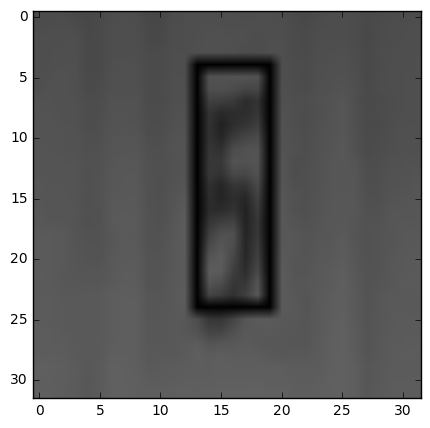

In [101]:
#print('predictions_train_bbox=',predictions_train_bbox.shape)
#predictions_train_bbox_ratio=predictions_train_bbox.reshape([batch_size,5,4])          
#print('prediction ratio bbox\n', predictions_train_bbox_ratio[0,:,:])
imgarr=test_dataset_raw[0].reshape([32,32])
print('image array=',imgarr.shape)
print('actualratiobox_raw=\n',test_ratioed_bboxes[0])
actualratiobox=test_ratioed_bboxes[0].reshape([4,5])
print('actualratiobbox=\n',actualratiobox)
actualscaledbackbbox=actualratiobox*32
actualscaledbackbbox=np.array(actualscaledbackbbox,dtype=int)
print('actual scaled back bbox=\n',actualscaledbackbbox)

img=Image.fromarray(imgarr)

top=actualscaledbackbbox[0,4]
left=actualscaledbackbbox[1,4]
height=actualscaledbackbbox[2,4] #(top,left,height,width) Size of Bounding Box 
width=actualscaledbackbbox[3,4]
print('(top,left,height,width)=\n',top,left,height,width)

bbox1 =  (left, top, left+width, top+height)
draw1 = ImageDraw.Draw(img)
draw1.rectangle(bbox1)
del draw1

plt.imshow(img)

In [23]:
test_ratioed_bboxes, test_dataset_raw, test_dataset, test_labels = openPng_saveBbox_downsample_crop(test_bboxdata,test_folder)
print('testset ratioed_bboxes=',test_ratioed_bboxes.shape)
print('testset test_dataset_raw=',test_dataset_raw.shape)
print('testset test_dataset=',test_dataset.shape)
print('testset test_label=',test_labels.shape)

extra_ratioed_bboxes, extra_dataset_raw, extra_dataset, extra_labels = openPng_saveBbox_downsample_crop(extra_bboxdata,extra_folder)
print('extraset ratioed_bboxes=',extra_ratioed_bboxes.shape)
print('extraset extra_dataset_raw=',extra_dataset_raw.shape)
print('extraset extra_dataset=',extra_dataset.shape)
print('extraset extra_label=',extra_labels.shape)

testset ratioed_bboxes= (13068, 20)
testset test_dataset_raw= (13068, 32, 32, 1)
testset test_dataset= (13068, 32, 32, 1)
testset test_label= (13068, 6)
extraset ratioed_bboxes= (202353, 20)
extraset extra_dataset_raw= (202353, 32, 32, 1)
extraset extra_dataset= (202353, 32, 32, 1)
extraset extra_label= (202353, 6)


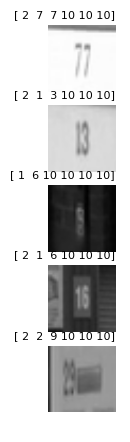

In [24]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
num_subplots=5
randomIndex=np.sort(np.random.randint(0, test_dataset.shape[0], size=num_subplots))

def display_Image_Label(num_subplots, dataset, data_labels):
    f, ax = plt.subplots(nrows=num_subplots, ncols=1)
    for i,j in enumerate(randomIndex):
        img=Image.fromarray(dataset[j,:,:].reshape([32,32]))
        ax[i].axis('off')
        ax[i].set_title(data_labels[j], loc='right',fontsize=8)
        ax[i].imshow(img)
    return

display_Image_Label(num_subplots, test_dataset_raw, test_labels)

[ 1  5 10 10 10 10]


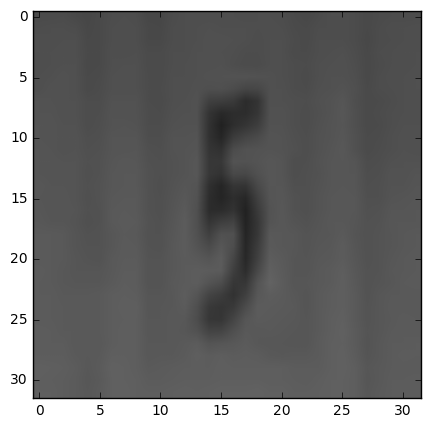

In [25]:
dataarry=test_dataset_raw[0].reshape([32,32])
print(test_labels[0])
im=Image.fromarray(dataarry)
f, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(im)

In [26]:
#Creating trainset, validset with extraset as [LeCunn '12](https://arxiv.org/pdf/1204.3968.pdf) proposed 
#as preprocessing the dataset

'''
The dataset is divided into three subsets: train set,extra set and test set. 
The extra set is a large set of easy samples and train set is a smaller set of more difficult samples. 
We compose our validation set with 2/3 from training samples (400 per class) and 1/3 from extra samples (200 per class),
yielding a total of 6000 samples. This distribution allows to measure
success on easy samples but puts more emphasis on difficult ones.
'''    
import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []

for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,1] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,1] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

shuffled_valid_dataset_raw = np.concatenate((extra_dataset_raw[valid_index2,:,:,:], train_dataset_raw[valid_index,:,:,:]), axis=0)
shuffled_valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
shuffled_valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
shuffled_valid_ratioed_bboxes = np.concatenate((extra_ratioed_bboxes[valid_index2,:], train_ratioed_bboxes[valid_index,:]), axis=0)

shuffled_train_dataset_raw = np.concatenate((extra_dataset_raw[train_index2,:,:,:], train_dataset_raw[train_index,:,:,:]), axis=0)
shuffled_train_dataset = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
shuffled_train_labels = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)
shuffled_train_ratioed_bboxes = np.concatenate((extra_ratioed_bboxes[train_index2,:], train_ratioed_bboxes[train_index,:]), axis=0)

print(shuffled_train_dataset_raw.shape, shuffled_train_dataset.shape, shuffled_train_labels.shape, shuffled_train_ratioed_bboxes.shape)
print(shuffled_valid_dataset_raw.shape, shuffled_valid_dataset.shape, shuffled_valid_labels.shape, shuffled_valid_ratioed_bboxes.shape)

(230070, 32, 32, 1) (230070, 32, 32, 1) (230070, 6) (230070, 20)
(5684, 32, 32, 1) (5684, 32, 32, 1) (5684, 6) (5684, 20)


In [27]:
from six.moves import cPickle as pickle
pickle_file = 'SVHN_multi_rationedbbox_and_downsampledrawimage.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset_raw': shuffled_train_dataset_raw,
    'train_dataset': shuffled_train_dataset,
    'train_labels': shuffled_train_labels,
    'train_ratioed_bboxes': shuffled_train_ratioed_bboxes,
    'valid_dataset_raw': shuffled_valid_dataset_raw,
    'valid_dataset': shuffled_valid_dataset,
    'valid_labels': shuffled_valid_labels,
    'valid_ratioed_bboxes': shuffled_valid_ratioed_bboxes,
    'test_dataset_raw': test_dataset_raw,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    'test_ratioed_bboxes': test_ratioed_bboxes,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 2070199846


In [4]:
#with the pickeled dataset from the preprocessing above. 

pickle_file = 'SVHN_multi_rationedbbox_and_downsampledrawimage.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_raw = save['train_dataset_raw']
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  train_ratioed_bboxes = save['train_ratioed_bboxes']
  valid_dataset_raw = save['valid_dataset_raw']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  valid_ratioed_bboxes = save['valid_ratioed_bboxes']
  test_dataset_raw = save['test_dataset_raw']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  test_ratioed_bboxes = save['test_ratioed_bboxes']
  del save  
    
  print('Training set', train_dataset_raw.shape, train_dataset.shape, train_labels.shape,train_ratioed_bboxes.shape)
  print('Validation set', valid_dataset_raw.shape, valid_dataset.shape, valid_labels.shape,valid_ratioed_bboxes.shape)
  print('Test set',test_dataset_raw.shape, test_dataset.shape, test_labels.shape,test_ratioed_bboxes.shape)

Training set (230070, 32, 32, 1) (230070, 32, 32, 1) (230070, 6) (230070, 20)
Validation set (5684, 32, 32, 1) (5684, 32, 32, 1) (5684, 6) (5684, 20)
Test set (13068, 32, 32, 1) (13068, 32, 32, 1) (13068, 6) (13068, 20)


In [5]:
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [122]:
# regression and classifiers

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset_raw = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size, 6))
  tf_train_ratioed_bboxes=tf.placeholder(tf.float32, shape=(batch_size, 20))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)  
  tf_valid_dataset_raw = tf.constant(valid_dataset_raw)
  tf_test_dataset_raw = tf.constant(test_dataset_raw)
  tf_valid_ratioed_bboxes=tf.constant(valid_ratioed_bboxes)
  tf_test_ratioed_bboxes=tf.constant(test_ratioed_bboxes)


  #variable
  #weight and biases for conv2d layers 
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth


  #digit classifier weight and biases for fully connected layer
  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

 
  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([W_fc_shape, 20], mean=0.0, stddev=1.0, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))


  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
  def regression_bbox(rawimgdata, bbox): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    error_bbox = tf.reduce_mean(tf.square(bbox - predictions_bbox))
    return [ predictions_bbox, error_bbox ]

  ##################################################################################
  ###Start of network architecture.
  ##################################################################################
  def bboxregressor(rawimgdata, ratioed_bboxes):
    #********Stage1**********
    conv=conv2d(rawimgdata, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 

    #********Stage2**********
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    #********Stage3**********
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    #Stage4-1: fully connected for bbox regression**********
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]])
    pred_bbox, cost_bbox = regression_bbox(h_pool3_flat, ratioed_bboxes)
    return [pred_bbox, cost_bbox]

  def digitclassifier(croppeddata, ratioed_bboxes):
    #********Stage1**********
    conv=conv2d(croppeddata, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 

    #********Stage2**********
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    #********Stage3**********
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    #********Stage4-2: fully connected for digit classifiers**********
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]])
  
    logits_0=tf.matmul(h_pool3_flat, W_fc_0) + b_fc_0 
    logits_1=tf.matmul(h_pool3_flat, W_fc_1) + b_fc_1
    logits_2=tf.matmul(h_pool3_flat, W_fc_2) + b_fc_2
    logits_3=tf.matmul(h_pool3_flat, W_fc_3) + b_fc_3
    logits_4=tf.matmul(h_pool3_flat, W_fc_4) + b_fc_4
    return [logits_0,logits_1,logits_2,logits_3,logits_4]
  ##################################################################################
  ###End of network architecture.
  ##################################################################################
    
  # Training computation.
  [pred_bbox, cost_bbox]=bboxregressor(tf_train_dataset_raw, tf_train_ratioed_bboxes)
  [logits_0,logits_1,logits_2,logits_3,logits_4] =digitclassifier(tf_train_dataset,tf_train_ratioed_bboxes)

  loss_digit =\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,0], logits=logits_0))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1], logits=logits_1))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2], logits=logits_2))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3], logits=logits_3))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4], logits=logits_4))
  

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 10000, 0.95)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  optimizer_digit = tf.train.AdagradOptimizer(learning_rate).minimize(loss_digit, global_step=global_step)
  optimizer_bbox = tf.train.AdagradOptimizer(learning_rate).minimize(cost_bbox, global_step=global_step)


  # Predictions for digit classification.
  train_prediction = tf.pack([tf.nn.softmax(digitclassifier(tf_train_dataset,tf_train_ratioed_bboxes)[0]),
                              tf.nn.softmax(digitclassifier(tf_train_dataset,tf_train_ratioed_bboxes)[1]),
                              tf.nn.softmax(digitclassifier(tf_train_dataset,tf_train_ratioed_bboxes)[2]),
                              tf.nn.softmax(digitclassifier(tf_train_dataset,tf_train_ratioed_bboxes)[3]),
                              tf.nn.softmax(digitclassifier(tf_train_dataset,tf_train_ratioed_bboxes)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(digitclassifier(tf_valid_dataset,tf_valid_ratioed_bboxes)[0]),
                              tf.nn.softmax(digitclassifier(tf_valid_dataset,tf_valid_ratioed_bboxes)[1]),
                              tf.nn.softmax(digitclassifier(tf_valid_dataset,tf_valid_ratioed_bboxes)[2]),
                              tf.nn.softmax(digitclassifier(tf_valid_dataset,tf_valid_ratioed_bboxes)[3]),
                              tf.nn.softmax(digitclassifier(tf_valid_dataset,tf_valid_ratioed_bboxes)[4])])
  test_prediction = tf.pack([tf.nn.softmax(digitclassifier(tf_test_dataset,tf_test_ratioed_bboxes)[0]),
                             tf.nn.softmax(digitclassifier(tf_test_dataset,tf_test_ratioed_bboxes)[1]),
                             tf.nn.softmax(digitclassifier(tf_test_dataset,tf_test_ratioed_bboxes)[2]),
                             tf.nn.softmax(digitclassifier(tf_test_dataset,tf_test_ratioed_bboxes)[3]),
                             tf.nn.softmax(digitclassifier(tf_test_dataset,tf_test_ratioed_bboxes)[4])])

  saver = tf.train.Saver()

num_steps = 10000 #230071
points = [[], []] # points[0]=n of iteration, points[1]=cost

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
     
    #bbox regression: (top,left,height,width)
    batch_data_bbox = train_dataset_raw[offset:(offset + batch_size), :, :, :]
    batch_labels_bbox = train_ratioed_bboxes[offset:(offset + batch_size), :]
    feed_dict_bbox = {tf_train_dataset_raw : batch_data_bbox, tf_train_ratioed_bboxes : batch_labels_bbox}
    _, l_bbox, predictions_train_bbox = session.run([optimizer_bbox, cost_bbox, pred_bbox], feed_dict=feed_dict_bbox)
 
    #digit classification
    #batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    #batch_labels = train_labels[offset:(offset + batch_size), :]
    #feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    #_, l_digit, predictions_train_digit = session.run([optimizer_digit, loss_digit, train_prediction],feed_dict=feed_dict)
   
        
    if (step % 50 == 0):
      print('Minibatch loss_bbox at step %d: %f' % (step, l_bbox))
      points[0].append(step+1)
      points[1].append(l_bbox)
      #print('Minibatch loss_digit at step %d: %f' % (step, l_digit))
      #print('Minibatch accuracy_digit: %.1f%%' % accuracy(predictions_train_digit, batch_labels[:,0:5])
      #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,0:5]))
  
      
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
  save_path = saver.save(session, "CNN_multi_two_stages_regressiononly.ckpt")
  print("Model saved in file: %s" % save_path)
  
  

Initialized
Minibatch loss_bbox at step 0: 12795262.000000
Minibatch loss_bbox at step 50: 5693.120605
Minibatch loss_bbox at step 100: 1709.252686
Minibatch loss_bbox at step 150: 858.466431
Minibatch loss_bbox at step 200: 613.382019
Minibatch loss_bbox at step 250: 408.321625
Minibatch loss_bbox at step 300: 5.946089
Minibatch loss_bbox at step 350: 11.700129
Minibatch loss_bbox at step 400: 1.300048
Minibatch loss_bbox at step 450: 0.105574
Minibatch loss_bbox at step 500: 4.874518
Minibatch loss_bbox at step 550: 0.119831
Minibatch loss_bbox at step 600: 0.390418
Minibatch loss_bbox at step 650: 50.427395
Minibatch loss_bbox at step 700: 8.007524
Minibatch loss_bbox at step 750: 1.130011
Minibatch loss_bbox at step 800: 0.107876
Minibatch loss_bbox at step 850: 0.179276
Minibatch loss_bbox at step 900: 0.092737
Minibatch loss_bbox at step 950: 0.101606
Minibatch loss_bbox at step 1000: 0.092927
Minibatch loss_bbox at step 1050: 0.112825
Minibatch loss_bbox at step 1100: 13.180410


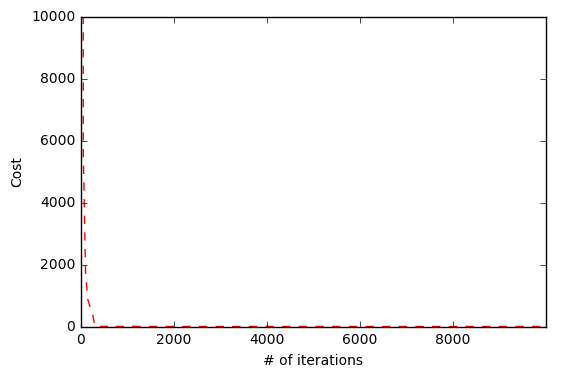

In [123]:
plt.plot(points[0], points[1], 'r--')
plt.axis([0, step, 0, 10000])
plt.xlabel('# of iterations')
plt.ylabel('Cost')
plt.show()

In [269]:
#Simplify regression only first

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset_raw = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  #tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size, 6))
  tf_train_ratioed_bboxes=tf.placeholder(tf.float32, shape=(batch_size, 20))
  #tf_valid_dataset = tf.constant(valid_dataset)
  #tf_test_dataset = tf.constant(test_dataset)  
  tf_valid_dataset_raw = tf.constant(valid_dataset_raw)
  tf_test_dataset_raw = tf.constant(test_dataset_raw)
  tf_valid_ratioed_bboxes=tf.constant(valid_ratioed_bboxes)
  tf_test_ratioed_bboxes=tf.constant(test_ratioed_bboxes)


  #variable
  #weight and biases for conv2d layers 
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth


  #digit classifier weight and biases for fully connected layer
  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

 
  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([W_fc_shape, 20], mean=0.0, stddev=1.0, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))


  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
  def regression_bbox(rawimgdata, bbox): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    error_bbox = tf.reduce_mean(tf.square(bbox - predictions_bbox))
    return [ predictions_bbox, error_bbox ]

  ##################################################################################
  ###Start of network architecture.
  ##################################################################################
  def bboxregressor(rawimgdata, ratioed_bboxes):
    #********Stage1**********
    conv=conv2d(rawimgdata, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 

    #********Stage2**********
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    #********Stage3**********
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    #Stage4-1: fully connected for bbox regression**********
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]])
    pred_bbox, cost_bbox = regression_bbox(h_pool3_flat, ratioed_bboxes)
    return [pred_bbox, cost_bbox]

 
  ##################################################################################
  ###End of network architecture.
  ##################################################################################
    
  # Training computation.
  [pred_bbox, cost_bbox]=bboxregressor(tf_train_dataset_raw, tf_train_ratioed_bboxes)
 
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 10000, 0.95)
  optimizer_bbox = tf.train.AdagradOptimizer(learning_rate).minimize(cost_bbox, global_step=global_step)


 
  saver = tf.train.Saver()

num_steps = 230071 #230071
points = [[], [], []] # points[0]=n of iteration, points[1]=cost, points[3]=accuracy

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
     
    #bbox regression: (top,left,height,width)
    batch_data_bbox = train_dataset_raw[offset:(offset + batch_size), :, :, :]
    batch_labels_bbox = train_ratioed_bboxes[offset:(offset + batch_size), :]
    feed_dict_bbox = {tf_train_dataset_raw : batch_data_bbox, tf_train_ratioed_bboxes : batch_labels_bbox}
    _, l_bbox, predictions_train_bbox = session.run([optimizer_bbox, cost_bbox, pred_bbox], feed_dict=feed_dict_bbox)
    
    #Get actual whole bbox area including all digits and calculate iou
    bbox_actual=find_wholebbox(step, batch_size, train_ratioed_bboxes)
    bbox_pred=find_wholebbox(step, batch_size, predictions_train_bbox)
    bbox_iou=get_iou(bbox_pred, bbox_actual, epsilon=1e-5)

    if (step % 50 == 0):
      print('Minibatch loss_bbox at step %d: %f' % (step, l_bbox))
      points[0].append(step+1)
      points[1].append(l_bbox)
      points[2].append(bbox_iou)
      print('Step', step, 'bbox accuracy: %.1f%%' % bbox_iou)
      
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
  save_path = saver.save(session, "CNN_multi_two_stages_regressiononly.ckpt")
  print("Model saved in file: %s" % save_path)



Initialized
Minibatch loss_bbox at step 0: 16610133.000000
Step 0 bbox accuracy: 0.0%
Minibatch loss_bbox at step 50: 31166.636719
Step 50 bbox accuracy: 0.0%
Minibatch loss_bbox at step 100: 19135.302734
Step 100 bbox accuracy: 0.0%
Minibatch loss_bbox at step 150: 17813.445312
Step 150 bbox accuracy: 0.0%
Minibatch loss_bbox at step 200: 9812.726562
Step 200 bbox accuracy: 0.0%
Minibatch loss_bbox at step 250: 14477.427734
Step 250 bbox accuracy: 0.0%
Minibatch loss_bbox at step 300: 9424.816406
Step 300 bbox accuracy: 0.0%
Minibatch loss_bbox at step 350: 6796.643555
Step 350 bbox accuracy: 0.0%
Minibatch loss_bbox at step 400: 5144.973633
Step 400 bbox accuracy: 0.0%
Minibatch loss_bbox at step 450: 3768.725098
Step 450 bbox accuracy: 0.0%
Minibatch loss_bbox at step 500: 4370.030762
Step 500 bbox accuracy: 0.0%
Minibatch loss_bbox at step 550: 4100.299805
Step 550 bbox accuracy: 0.0%
Minibatch loss_bbox at step 600: 3162.352783
Step 600 bbox accuracy: 0.0%
Minibatch loss_bbox at s

In [2]:
#bbox accuracy 

def get_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)*100
    return iou

def batch_iou(a, b, epsilon=1e-5):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union scores for each corresponding
        pair of boxes.

    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (numpy array) The Intersect of Union scores for each pair of bounding
        boxes.
    """
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a[:, 2], b[:, 2]]).min(axis=0)
    y2 = np.array([a[:, 3], b[:, 3]]).min(axis=0)

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width[width < 0] = 0
    height[height < 0] = 0

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)*100
    return iou

In [8]:
#Simplify regression only first

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset_raw = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_ratioed_bboxes=tf.placeholder(tf.float32, shape=(batch_size, 20))
  tf_valid_dataset_raw = tf.constant(valid_dataset_raw)
  tf_test_dataset_raw = tf.constant(test_dataset_raw)
  tf_valid_ratioed_bboxes=tf.constant(valid_ratioed_bboxes)
  tf_test_ratioed_bboxes=tf.constant(test_ratioed_bboxes)


  #variable
  
  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([32*32, 20], mean=0.0, stddev=1.0, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))


  def regression_bbox(rawimgdata, bbox): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    error_bbox = tf.reduce_mean(tf.square(bbox - predictions_bbox))
    return [ predictions_bbox, error_bbox ]

  

  ##################################################################################
  ###Start of network architecture.
  ##################################################################################
  
    
  
  def bboxregressor(rawimgdata, ratioed_bboxes):
    #Stage4-1: fully connected for bbox regression**********
    h_fc_flat = tf.reshape(rawimgdata, (-1, image_size*image_size))
    pred_bbox, cost_bbox = regression_bbox(h_fc_flat, ratioed_bboxes)
    return [pred_bbox, cost_bbox]
 
  ##################################################################################
  ###End of network architecture.
  ##################################################################################
    
  # Training computation.
  [pred_bbox, cost_bbox]=bboxregressor(tf_train_dataset_raw, tf_train_ratioed_bboxes)
 
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 10000, 0.95)
  optimizer_bbox = tf.train.AdagradOptimizer(learning_rate).minimize(cost_bbox, global_step=global_step)

 
  saver = tf.train.Saver()

num_steps = 100000 #230071
points = [[], [], []] # points[0]=n of iteration, points[1]=cost, points[3]=accuracy

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
     
    #bbox regression: (top,left,height,width)
    batch_data_bbox = train_dataset_raw[offset:(offset + batch_size), :, :, :]
    batch_labels_bbox = train_ratioed_bboxes[offset:(offset + batch_size), :]
    feed_dict_bbox = {tf_train_dataset_raw : batch_data_bbox, tf_train_ratioed_bboxes : batch_labels_bbox}
    _, l_bbox, predictions_train_bbox = session.run([optimizer_bbox, cost_bbox, pred_bbox], feed_dict=feed_dict_bbox)
    
    #Get actual whole bbox area including all digits and calculate iou
    bbox_actual=find_wholebbox(step, batch_size, train_ratioed_bboxes)
    bbox_pred=find_wholebbox(step, batch_size, predictions_train_bbox)
    bbox_iou=get_iou(bbox_pred, bbox_actual, epsilon=1e-5)

    if (step % 50 == 0):
      print('Minibatch loss_bbox at step %d: %f' % (step, l_bbox))
      points[0].append(step+1)
      points[1].append(l_bbox)
      points[2].append(bbox_iou)
      print('Step', step, 'bbox accuracy: %.1f%%' % bbox_iou)
      
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
  save_path = saver.save(session, "CNN_multi_two_stages_fc_regressiononly.ckpt")
  print("Model saved in file: %s" % save_path)



Initialized
Minibatch loss_bbox at step 0: 11208259.000000
Step 0 bbox accuracy: 0.0%
Minibatch loss_bbox at step 50: 845023.187500
Step 50 bbox accuracy: 0.0%
Minibatch loss_bbox at step 100: 587355.500000
Step 100 bbox accuracy: 0.0%
Minibatch loss_bbox at step 150: 663562.750000
Step 150 bbox accuracy: 0.0%
Minibatch loss_bbox at step 200: 512060.312500
Step 200 bbox accuracy: 0.0%
Minibatch loss_bbox at step 250: 740202.625000
Step 250 bbox accuracy: 0.0%
Minibatch loss_bbox at step 300: 483939.000000
Step 300 bbox accuracy: 0.0%
Minibatch loss_bbox at step 350: 529136.250000
Step 350 bbox accuracy: 0.0%
Minibatch loss_bbox at step 400: 432125.187500
Step 400 bbox accuracy: 0.0%
Minibatch loss_bbox at step 450: 451412.187500
Step 450 bbox accuracy: 0.0%
Minibatch loss_bbox at step 500: 494729.906250
Step 500 bbox accuracy: 0.0%
Minibatch loss_bbox at step 550: 533454.187500
Step 550 bbox accuracy: 0.0%
Minibatch loss_bbox at step 600: 388073.593750
Step 600 bbox accuracy: 0.0%
Mini

In [64]:
#Simplify regression only first

image_size=32
num_labels=11
num_channels=1

batch_size = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset_raw = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_ratioed_bboxes=tf.placeholder(tf.float32, shape=(batch_size, 20))
  tf_valid_dataset_raw = tf.constant(valid_dataset_raw)
  tf_test_dataset_raw = tf.constant(test_dataset_raw)
  tf_valid_ratioed_bboxes=tf.constant(valid_ratioed_bboxes)
  tf_test_ratioed_bboxes=tf.constant(test_ratioed_bboxes)


  #variable
  
  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([32*32, 20], stddev=0.1, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))


  def regression_bbox(rawimgdata, bbox): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    error_bbox = tf.reduce_mean(tf.square((bbox[:,0] - predictions_bbox[:,0]))+
                                tf.square((bbox[:,1] - predictions_bbox[:,1]))+
                                tf.square((bbox[:,2] - predictions_bbox[:,2]))+
                                tf.square((bbox[:,3] - predictions_bbox[:,3]))+
                                tf.square((bbox[:,4] - predictions_bbox[:,4]))+
                                tf.square((bbox[:,5] - predictions_bbox[:,5]))+
                                tf.square((bbox[:,6] - predictions_bbox[:,6]))+
                                tf.square((bbox[:,7] - predictions_bbox[:,7]))+
                                tf.square((bbox[:,8] - predictions_bbox[:,8]))+
                                tf.square((bbox[:,9] - predictions_bbox[:,9]))+
                                tf.square((bbox[:,10] - predictions_bbox[:,10]))+
                                tf.square((bbox[:,11] - predictions_bbox[:,11]))+
                                tf.square((bbox[:,12] - predictions_bbox[:,12]))+
                                tf.square((bbox[:,13] - predictions_bbox[:,13]))+
                                tf.square((bbox[:,14] - predictions_bbox[:,14]))+
                                tf.square((bbox[:,15] - predictions_bbox[:,15]))+
                                tf.square((bbox[:,16] - predictions_bbox[:,16]))+
                                tf.square((bbox[:,17] - predictions_bbox[:,17]))+
                                tf.square((bbox[:,18] - predictions_bbox[:,18]))+
                                tf.square((bbox[:,19] - predictions_bbox[:,19]))
                               )
    #error_bbox = tf.reduce_mean(tf.square(bbox - predictions_bbox))
    return [ predictions_bbox, error_bbox ]

  
  ##################################################################################
  ###Start of network architecture.
  ##################################################################################
  
  # Training computation.
  h_fc_flat = tf.reshape(tf_train_dataset_raw, (-1, image_size*image_size))
  #print('h_fc_flat=',h_fc_flat.get_shape())
  pred_bbox, cost_bbox = regression_bbox(h_fc_flat, tf_train_ratioed_bboxes)
  
 
  ##################################################################################
  ###End of network architecture.
  ##################################################################################

 
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 10000, 0.95)
  optimizer_bbox = tf.train.AdagradOptimizer(learning_rate).minimize(cost_bbox, global_step=global_step)

 
  saver = tf.train.Saver()

num_steps = 230071 #230071
points = [[], [], []] # points[0]=n of iteration, points[1]=cost, points[3]=accuracy

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
     
    #bbox regression: (top,left,height,width)
    batch_data_bbox = train_dataset_raw[offset:(offset + batch_size), :, :, :]
    batch_labels_bbox = train_ratioed_bboxes[offset:(offset + batch_size), :]
    feed_dict_bbox = {tf_train_dataset_raw : batch_data_bbox, tf_train_ratioed_bboxes : batch_labels_bbox}
    _, l_bbox, predictions_train_bbox = session.run([optimizer_bbox, cost_bbox, pred_bbox], feed_dict=feed_dict_bbox)
    
    #Get actual whole bbox area including all digits and calculate iou
    bbox_actual=find_wholebbox(step, train_ratioed_bboxes)
    bbox_pred=find_wholebbox(step, predictions_train_bbox)
    bbox_iou=get_iou(bbox_pred, bbox_actual, epsilon=1e-5)

    if (step % 100 == 0):
      print('Minibatch loss_bbox at step %d: %f' % (step, l_bbox))
      points[0].append(step+1)
      points[1].append(l_bbox)
      points[2].append(bbox_iou)
      print('Step', step, 'bbox accuracy: %.1f%%' % bbox_iou)
      
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
  save_path = saver.save(session, "CNN_multi_two_stages_fc_regressiononly.ckpt")
  print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss_bbox at step 0: 2426193.000000
Step 0 bbox accuracy: 0.0%
Minibatch loss_bbox at step 100: 75196.343750
Step 100 bbox accuracy: 0.0%
Minibatch loss_bbox at step 200: 62754.304688
Step 200 bbox accuracy: 0.0%
Minibatch loss_bbox at step 300: 61078.542969
Step 300 bbox accuracy: 0.0%
Minibatch loss_bbox at step 400: 54648.882812
Step 400 bbox accuracy: 0.0%
Minibatch loss_bbox at step 500: 60238.890625
Step 500 bbox accuracy: 0.0%
Minibatch loss_bbox at step 600: 47090.914062
Step 600 bbox accuracy: 0.0%
Minibatch loss_bbox at step 700: 51622.828125
Step 700 bbox accuracy: 0.0%
Minibatch loss_bbox at step 800: 47422.199219
Step 800 bbox accuracy: 0.0%
Minibatch loss_bbox at step 900: 38915.921875
Step 900 bbox accuracy: 0.0%
Minibatch loss_bbox at step 1000: 35541.828125
Step 1000 bbox accuracy: 0.0%
Minibatch loss_bbox at step 1100: 48267.546875
Step 1100 bbox accuracy: 0.0%
Minibatch loss_bbox at step 1200: 34364.125000
Step 1200 bbox accuracy: 0.0%
Minibatch

In [75]:
print('pred=\n',predictions_train_bbox[0].reshape([4,5]))
print('actual=\n',train_ratioed_bboxes[0].reshape([4,5]))

pred=
 [[-4.70086241 -2.04922485 -5.51422787 -6.72599077  4.423522  ]
 [ 3.43598485  2.88345194 -4.11899281 -4.05116272 -0.73277152]
 [ 2.54261136  1.83367908  4.09127712  2.85542965  1.88157809]
 [ 2.34052253  1.11986232 -0.91085368  3.55356741 -6.20845079]]
actual=
 [[ 0.          0.          0.          0.21568628  0.27450982]
 [ 0.          0.          0.          0.1724138   0.39655173]
 [ 0.          0.          0.          0.56862748  0.56862748]
 [ 0.          0.          0.          0.22413793  0.25862068]]


In [80]:
#full convnet and L2 distance afterwards

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset_raw = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  #tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size, 6))
  tf_train_ratioed_bboxes=tf.placeholder(tf.float32, shape=(batch_size, 20))
  #tf_valid_dataset = tf.constant(valid_dataset)
  #tf_test_dataset = tf.constant(test_dataset)  
  tf_valid_dataset_raw = tf.constant(valid_dataset_raw)
  tf_test_dataset_raw = tf.constant(test_dataset_raw)
  tf_valid_ratioed_bboxes=tf.constant(valid_ratioed_bboxes)
  tf_test_ratioed_bboxes=tf.constant(test_ratioed_bboxes)


  #variable
  #weight and biases for conv2d layers 
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth


  #digit classifier weight and biases for fully connected layer
  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

 
  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([W_fc_shape, 20], stddev=0.1, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))


  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
  def regression_bbox(rawimgdata, bbox): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    error_bbox = tf.reduce_mean(tf.square((bbox[:,0] - predictions_bbox[:,0]))+
                                tf.square((bbox[:,1] - predictions_bbox[:,1]))+
                                tf.square((bbox[:,2] - predictions_bbox[:,2]))+
                                tf.square((bbox[:,3] - predictions_bbox[:,3]))+
                                tf.square((bbox[:,4] - predictions_bbox[:,4]))+
                                tf.square((bbox[:,5] - predictions_bbox[:,5]))+
                                tf.square((bbox[:,6] - predictions_bbox[:,6]))+
                                tf.square((bbox[:,7] - predictions_bbox[:,7]))+
                                tf.square((bbox[:,8] - predictions_bbox[:,8]))+
                                tf.square((bbox[:,9] - predictions_bbox[:,9]))+
                                tf.square((bbox[:,10] - predictions_bbox[:,10]))+
                                tf.square((bbox[:,11] - predictions_bbox[:,11]))+
                                tf.square((bbox[:,12] - predictions_bbox[:,12]))+
                                tf.square((bbox[:,13] - predictions_bbox[:,13]))+
                                tf.square((bbox[:,14] - predictions_bbox[:,14]))+
                                tf.square((bbox[:,15] - predictions_bbox[:,15]))+
                                tf.square((bbox[:,16] - predictions_bbox[:,16]))+
                                tf.square((bbox[:,17] - predictions_bbox[:,17]))+
                                tf.square((bbox[:,18] - predictions_bbox[:,18]))+
                                tf.square((bbox[:,19] - predictions_bbox[:,19]))
                               )
    #error_bbox = tf.reduce_mean(tf.square(bbox - predictions_bbox))
    return [ predictions_bbox, error_bbox ]


  ##################################################################################
  ###Start of network architecture.
  ##################################################################################
  def bboxregressor(rawimgdata, ratioed_bboxes):
    #********Stage1**********
    conv=conv2d(rawimgdata, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 

    #********Stage2**********
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    #********Stage3**********
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    #Stage4-1: fully connected for bbox regression**********
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]])
    pred_bbox, cost_bbox = regression_bbox(h_pool3_flat, ratioed_bboxes)
    return [pred_bbox, cost_bbox]

 
  ##################################################################################
  ###End of network architecture.
  ##################################################################################
    
  # Training computation.
  [pred_bbox, cost_bbox]=bboxregressor(tf_train_dataset_raw, tf_train_ratioed_bboxes)
 
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 10000, 0.95)
  optimizer_bbox = tf.train.AdagradOptimizer(learning_rate).minimize(cost_bbox, global_step=global_step)


 
  saver = tf.train.Saver()

num_steps = 10000 #230071
points = [[], [], []] # points[0]=n of iteration, points[1]=cost, points[3]=accuracy

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
     
    #bbox regression: (top,left,height,width)
    batch_data_bbox = train_dataset_raw[offset:(offset + batch_size), :, :, :]
    batch_labels_bbox = train_ratioed_bboxes[offset:(offset + batch_size), :]
    feed_dict_bbox = {tf_train_dataset_raw : batch_data_bbox, tf_train_ratioed_bboxes : batch_labels_bbox}
    _, l_bbox, predictions_train_bbox = session.run([optimizer_bbox, cost_bbox, pred_bbox], feed_dict=feed_dict_bbox)
    
    #Get actual whole bbox area including all digits and calculate iou
    bbox_actual=find_wholebbox(step, train_ratioed_bboxes)
    bbox_pred=find_wholebbox(step, predictions_train_bbox)
    bbox_iou=get_iou(bbox_pred, bbox_actual, epsilon=1e-5)

    if (step % 100 == 0):
      print('Minibatch loss_bbox at step %d: %f' % (step, l_bbox))
      points[0].append(step+1)
      points[1].append(l_bbox)
      points[2].append(bbox_iou)
      print('Step', step, 'bbox accuracy: %.1f%%' % bbox_iou)
      
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
  save_path = saver.save(session, "CNN_multi_two_stages_regressiononly_tmp.ckpt")
  print("Model saved in file: %s" % save_path)



Initialized
Minibatch loss_bbox at step 0: 1653122.250000
Step 0 bbox accuracy: 0.0%
Minibatch loss_bbox at step 100: 1173.372803
Step 100 bbox accuracy: 0.0%
Minibatch loss_bbox at step 200: 365.087646
Step 200 bbox accuracy: 0.0%
Minibatch loss_bbox at step 300: 148.373901
Step 300 bbox accuracy: 0.0%
Minibatch loss_bbox at step 400: 39.526009
Step 400 bbox accuracy: 0.0%
Minibatch loss_bbox at step 500: 13.723961
Step 500 bbox accuracy: 0.0%
Minibatch loss_bbox at step 600: 4.202520
Step 600 bbox accuracy: 0.0%
Minibatch loss_bbox at step 700: 14.697073
Step 700 bbox accuracy: 0.0%
Minibatch loss_bbox at step 800: 2.456696
Step 800 bbox accuracy: 0.0%
Minibatch loss_bbox at step 900: 2.225415
Step 900 bbox accuracy: 0.0%
Minibatch loss_bbox at step 1000: 2.492371
Step 1000 bbox accuracy: 0.0%
Minibatch loss_bbox at step 1100: 3.812257
Step 1100 bbox accuracy: 5.8%
Minibatch loss_bbox at step 1200: 1.722515
Step 1200 bbox accuracy: 0.0%
Minibatch loss_bbox at step 1300: 2.561475
Step

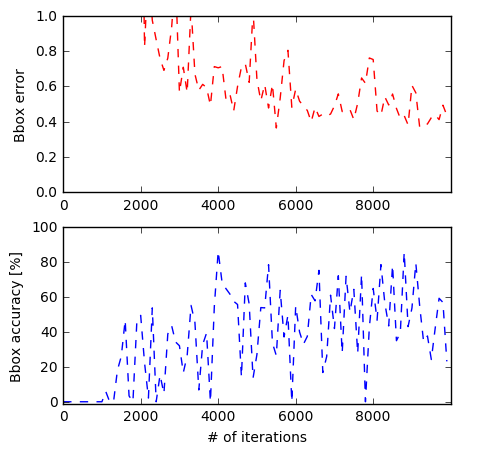

In [86]:
#Loss and accuracy over training 

fig = plt.figure()
ax = fig.add_subplot(111)    # The big subplot
ax.axis('off')
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)

ax1.plot(points[0], points[1], 'r--')
ax2.plot(points[0], points[2], 'b--')

ax2.set_xlabel('# of iterations')

ax1.axis([0, step, 0, 1])
ax1.set_ylabel('Bbox error')

ax2.axis([0, step, -1, 100])
ax2.set_ylabel('Bbox accuracy [%]')


In [ ]:
#restoring model = bbox regression
image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no pooling, no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_test_dataset_raw=tf.placeholder(tf.float32, shape=(10, image_size, image_size, num_channels))

  #variable
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth

  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([W_fc_shape, 20], stddev=0.1, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
  def regression_bbox(rawimgdata): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    return [ predictions_bbox]

  def bboxregressor(rawimgdata, ratioed_bboxes):
    #********Stage1**********
    conv=conv2d(rawimgdata, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 

    #********Stage2**********
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    #********Stage3**********
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    #Stage4-1: fully connected for bbox regression**********
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]])
    pred_bbox = regression_bbox(h_pool3_flat)
    return pred_bbox

  # Training computation.
  pred_bbox=bboxregressor(tf_test_dataset_raw)
  test_prediction = tf.transpose(tf.argmax(pred_bbox, 2))
  saver = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver.restore(session, "CNN_multi_two_stages_regressiononly_tmp.ckpt")
  print("Model restored.")  
  test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset_raw : test_dataset[im_samples,:,:,:],})

n= 32


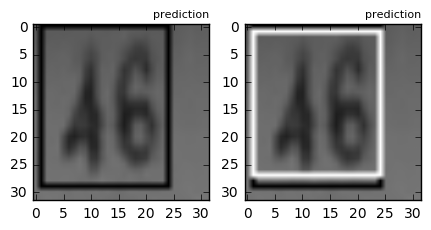

In [100]:
#Open raw image, draw actual bbox vs. prediction bbox

plt.rcParams['figure.figsize'] = (5.0, 5.0)
nplots=2
f, ax = plt.subplots(nrows=1, ncols=nplots)
    
import random
n=random.randint(0,63) # 
print('n=',n)
imgarr=train_dataset_raw[n].reshape([32,32])
img=Image.fromarray(imgarr)

def find_wholebbox(step, train_ratioed_bboxes):
    -


def draw_bbox(nplots, img, bbox):
    draw = ImageDraw.Draw(img)
    if nplots==1: color='black' 
    else: color='white'
    draw.rectangle(bbox,outline=color)
    del draw
    ax[nplots-1].set_title('prediction',loc='right', fontsize=8)
    ax[nplots-1].imshow(img)
    pass

###################
#ACTUAL BBOX
###################
bbox_actual=find_wholebbox(n, train_ratioed_bboxes)
draw_bbox(nplots-1,img, bbox_actual)

###################
#PREDICTION BBOX
###################
bbox_pred=find_wholebbox(n, predictions_train_bbox)
draw_bbox(nplots,img, bbox_pred)


testsample= (5, 32, 32, 1)
testlabels= [[6767]
 [1363]
 [2011]
 [3951]
 [ 544]]


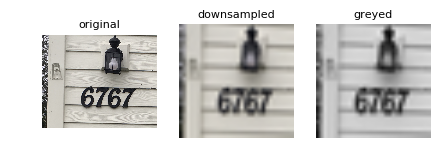

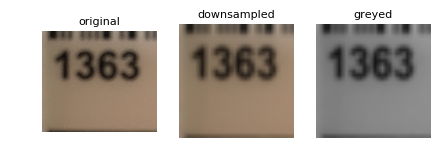

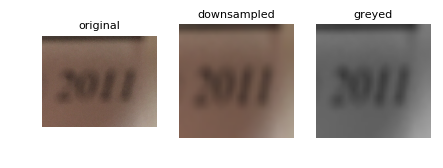

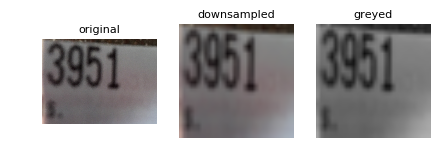

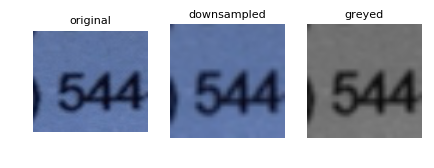

In [169]:
#test sample pre-processing

plt.rcParams['figure.figsize'] = (5.0, 5.0)
testsample=np.ndarray([5,32,32,1], dtype='float32')
testlabels=np.ndarray([5,1], dtype='int32')


def openjpg_resize_grey(filename,i):
    fig = plt.figure()
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    im=Image.open('./camerapictures/'+ filename+'.jpg')
    ax1.imshow(im)
    ax1.set_title('original', fontsize=8)
    ax1.axis('off')
    im=im.resize([32,32],Image.LANCZOS)
    ax2.imshow(im)
    ax2.set_title('downsampled', fontsize=8)
    ax2.axis('off')
    im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
    testsample[i,:,:,:]=im[:,:,:]
    im=Image.fromarray(im.reshape([32,32]))
    ax3.imshow(im)
    ax3.set_title('greyed', fontsize=8)
    ax3.axis('off')   
    testlabels[i,:]=int(filename)
    pass

openjpg_resize_grey('6767',0)
openjpg_resize_grey('1363',1)
openjpg_resize_grey('2011',2)
openjpg_resize_grey('3951',3)
openjpg_resize_grey('544',4)

print('testsample=',testsample.shape)
print('testlabels=',testlabels)

In [194]:
#restoring model =digit classification

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no pooling, no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_testsample=tf.placeholder(tf.float32, shape=(6, image_size, image_size, num_channels))

  #variable
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth

  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  # network architecture.
  def model(data):
 
    ######Stage1########
    conv=conv2d(data, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1)
    
    ######Stage2########
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    ######Stage3########
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    ######Stage4=fully connected and dropout ########
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]]) 
    logits_0=tf.matmul(h_pool3_flat, W_fc_0) + b_fc_0 
    logits_1=tf.matmul(h_pool3_flat, W_fc_1) + b_fc_1
    logits_2=tf.matmul(h_pool3_flat, W_fc_2) + b_fc_2
    logits_3=tf.matmul(h_pool3_flat, W_fc_3) + b_fc_3
    logits_4=tf.matmul(h_pool3_flat, W_fc_4) + b_fc_4
    
    return [logits_0,logits_1,logits_2,logits_3,logits_4]
  
  # Training computation.
  [logits_0,logits_1,logits_2,logits_3,logits_4] = model(tf_testsample)
  
  # Predictions for the training, validation, and test data.
  predict = tf.pack([tf.nn.softmax(logits_0), 
                     tf.nn.softmax(logits_1), 
                     tf.nn.softmax(logits_2),
                     tf.nn.softmax(logits_3),
                     tf.nn.softmax(logits_4)])
  test_prediction = tf.transpose(tf.argmax(predict, 2))
  saver = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver.restore(session, "CNN_multi_two_stages_final.ckpt")
  print("Model restored.")  
  test_prediction = session.run(test_prediction, feed_dict={tf_testsample : testsample})
  print('test_prediction=\n',test_prediction)
  print('Actual testlabels=\n[[ 6767.]\n[ 1363.]\n[ 2011.]\n[ 3951.]\n[  544.]]')

Model restored.
test_prediction=
 [[ 1  1 10 10 10]
 [ 4  1  3 10  0]
 [ 1  9 10 10  0]
 [ 3  6  2  5  0]
 [ 3  2  4  4 10]
 [ 1  6 10 10 10]]
Actual testlabels=
[[ 6767.]
[ 1363.]
[ 2011.]
[ 3951.]
[  544.]]


In [ ]:
def cropimage(rawimgdata, ratioed_bboxes):
    
    ratiobox=ratioed_bboxes.reshape([4,5])
    print('ratiobox=\n',ratiobox)
    scaledbackbbox=ratiobox*32
    scaledbackbbox=np.array(scaledbackbbox, dtype=int)
    croppedimgdata = np.ndarray([32,32], dtype='float32') #len(rawimgdata),32,32,1
    print('scaledbackbbox=\n',scaledbackbbox)
    
    print('scaledbackbbox[0,:]=\n',scaledbackbbox[0,:])
    
    # bounding box information of area encompassing all digits
    im_top = min([x for x in scaledbackbbox[0,:] if x > 0]) 
    im_left = min([x for x in scaledbackbbox[1,:] if x > 0])  
    im_height = np.amax(scaledbackbbox[0,:]) + scaledbackbbox[2,[np.argmax(scaledbackbbox[0,:])]] - im_top
    im_width = np.amax(scaledbackbbox[1,:]) + scaledbackbbox[3,[np.argmax(scaledbackbbox[1,:])]] - im_left

    # resize bounding box and create points to crop 
    im_top = np.floor(1.0*im_top - 0.1 * im_height)
    im_left = np.floor(1.0*im_left - 0.1 * im_width)
    im_bottom = np.amin([np.ceil(1.0*im_top + 1.2 * im_height), 32])
    im_right = np.amin([np.ceil(1.0*im_left + 1.2 * im_width), 32])
    
    print('rawimgdata=',rawimgdata.reshape([32,32]).shape)
    im = Image.fromarray(rawimgdata.reshape([32,32])) 
    im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
    im = np.array(im, dtype='float32')
   
    croppedimgdata[:,:] = im[:,:]
    return croppedimgdata

n=random.randint(0,64)
crpdata=cropimage(train_dataset_raw[n], train_ratioed_bboxes[n])

fig=plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.imshow(Image.fromarray(train_dataset_raw[n].reshape([32,32])))
ax2.imshow(Image.fromarray(crpdata))

testsample= (5, 32, 32, 1)
test_dataset_raw[0]= (32, 32, 1)
(6, 32, 32, 1) (6, 1)


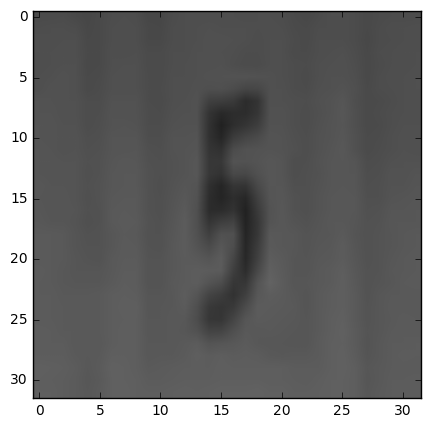

In [193]:
#pull a sample image from testset and see prediction works 

im_tmp=Image.fromarray(test_dataset_raw[0].reshape([32,32]))
fig=plt.figure()
ax=fig.add_subplot(111)
ax.imshow(im_tmp)

print('testsample=',testsample.shape)
print('test_dataset_raw[0]=',test_dataset_raw[0].shape)
reshape=test_dataset_raw[0].reshape([1,32,32,1])
testsample=np.concatenate((testsample,reshape), axis=0)
lb=[5]
lb_res=np.array(lb).reshape([1,1])
testlabels=np.concatenate((testlabels,lb_res))
print(testsample.shape,testlabels.shape)

In [ ]:
# raw image is fed to both regression and classifiers at the same time. digit classification accuracy is pretty low. 

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset_raw = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size, 6))
  tf_train_ratioed_bboxes=tf.placeholder(tf.float32, shape=(batch_size, 20))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)  
  tf_valid_dataset_raw = tf.constant(valid_dataset_raw)
  tf_test_dataset_raw = tf.constant(test_dataset_raw)
  tf_valid_ratioed_bboxes=tf.constant(valid_ratioed_bboxes)
  tf_test_ratioed_bboxes=tf.constant(test_ratioed_bboxes)


  #variable
  #weight and biases for conv2d layers 
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth


  #digit classifier weight and biases for fully connected layer
  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

 
  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([W_fc_shape, 20], mean=0.0, stddev=1.0, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))


  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
  def regression_bbox(rawimgdata, bbox): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    error_bbox = tf.reduce_mean(tf.square((bbox[:,0] - predictions_bbox[:,0]))+
                                tf.square((bbox[:,1] - predictions_bbox[:,1]))+
                                tf.square((bbox[:,2] - predictions_bbox[:,2]))+
                                tf.square((bbox[:,3] - predictions_bbox[:,3]))+
                                tf.square((bbox[:,4] - predictions_bbox[:,4]))+
                                tf.square((bbox[:,5] - predictions_bbox[:,5]))+
                                tf.square((bbox[:,6] - predictions_bbox[:,6]))+
                                tf.square((bbox[:,7] - predictions_bbox[:,7]))+
                                tf.square((bbox[:,8] - predictions_bbox[:,8]))+
                                tf.square((bbox[:,9] - predictions_bbox[:,9]))+
                                tf.square((bbox[:,10] - predictions_bbox[:,10]))+
                                tf.square((bbox[:,11] - predictions_bbox[:,11]))+
                                tf.square((bbox[:,12] - predictions_bbox[:,12]))+
                                tf.square((bbox[:,13] - predictions_bbox[:,13]))+
                                tf.square((bbox[:,14] - predictions_bbox[:,14]))+
                                tf.square((bbox[:,15] - predictions_bbox[:,15]))+
                                tf.square((bbox[:,16] - predictions_bbox[:,16]))+
                                tf.square((bbox[:,17] - predictions_bbox[:,17]))+
                                tf.square((bbox[:,18] - predictions_bbox[:,18]))+
                                tf.square((bbox[:,19] - predictions_bbox[:,19]))
                               )
    #error_bbox = tf.reduce_mean(tf.square(bbox - predictions_bbox))
    return [ predictions_bbox, error_bbox ]


  ##################################################################################
  ###Start of network architecture.
  ##################################################################################
  def model(rawimgdata, ratioed_bboxes):
    
    #********Stage1**********
    conv=conv2d(rawimgdata, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 

    #********Stage2**********
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    #********Stage3**********
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    #Stage4-1: fully connected for bbox regression**********
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]])
    pred_bbox, cost_bbox = regression_bbox(h_pool3_flat, ratioed_bboxes)
    
    logits_0=tf.matmul(h_pool3_flat, W_fc_0) + b_fc_0 
    logits_1=tf.matmul(h_pool3_flat, W_fc_1) + b_fc_1
    logits_2=tf.matmul(h_pool3_flat, W_fc_2) + b_fc_2
    logits_3=tf.matmul(h_pool3_flat, W_fc_3) + b_fc_3
    logits_4=tf.matmul(h_pool3_flat, W_fc_4) + b_fc_4

    return [logits_0,logits_1,logits_2,logits_3,logits_4, pred_bbox, cost_bbox]

    
  ##################################################################################
  ###End of network architecture.
  ##################################################################################
    
  # Training computation.
  [logits_0,logits_1,logits_2,logits_3,logits_4,pred_bbox, cost_bbox] =model(tf_train_dataset_raw,tf_train_ratioed_bboxes)

  loss_digit =\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,0], logits=logits_0))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1], logits=logits_1))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2], logits=logits_2))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3], logits=logits_3))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4], logits=logits_4))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 10000, 0.95)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  optimizer_digit = tf.train.AdagradOptimizer(learning_rate).minimize(loss_digit, global_step=global_step)
  optimizer_bbox = tf.train.AdagradOptimizer(learning_rate).minimize(cost_bbox, global_step=global_step)

  # Predictions for digit classification.
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset_raw,tf_train_ratioed_bboxes)[0]),
                              tf.nn.softmax(model(tf_train_dataset_raw,tf_train_ratioed_bboxes)[1]),
                              tf.nn.softmax(model(tf_train_dataset_raw,tf_train_ratioed_bboxes)[2]),
                              tf.nn.softmax(model(tf_train_dataset_raw,tf_train_ratioed_bboxes)[3]),
                              tf.nn.softmax(model(tf_train_dataset_raw,tf_train_ratioed_bboxes)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset_raw,tf_valid_ratioed_bboxes)[0]),
                              tf.nn.softmax(model(tf_valid_dataset_raw,tf_valid_ratioed_bboxes)[1]),
                              tf.nn.softmax(model(tf_valid_dataset_raw,tf_valid_ratioed_bboxes)[2]),
                              tf.nn.softmax(model(tf_valid_dataset_raw,tf_valid_ratioed_bboxes)[3]),
                              tf.nn.softmax(model(tf_valid_dataset_raw,tf_valid_ratioed_bboxes)[4])])
  test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset_raw,tf_test_ratioed_bboxes)[0]),
                             tf.nn.softmax(model(tf_test_dataset_raw,tf_test_ratioed_bboxes)[1]),
                             tf.nn.softmax(model(tf_test_dataset_raw,tf_test_ratioed_bboxes)[2]),
                             tf.nn.softmax(model(tf_test_dataset_raw,tf_test_ratioed_bboxes)[3]),
                             tf.nn.softmax(model(tf_test_dataset_raw,tf_test_ratioed_bboxes)[4])])

  saver = tf.train.Saver()

num_steps = 1000 #230071
points = [[], [], []] # points[0]=n of iteration, points[1]=cost, points[3]=accuracy

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
     
    #bbox regression: (top,left,height,width)
    batch_data_bbox = train_dataset_raw[offset:(offset + batch_size), :, :, :]
    batch_labels_bbox = train_ratioed_bboxes[offset:(offset + batch_size), :]
    feed_dict_bbox = {tf_train_dataset_raw : batch_data_bbox, tf_train_ratioed_bboxes : batch_labels_bbox}
    _, l_bbox, predictions_train_bbox = session.run([optimizer_bbox, cost_bbox, pred_bbox], feed_dict=feed_dict_bbox)
 
    #digit classification
    batch_data = train_dataset_raw[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset_raw : batch_data, tf_train_labels : batch_labels}
    _, l_digit, predictions_train_digit = session.run([optimizer_digit, loss_digit, train_prediction],feed_dict=feed_dict)
    
    #Get actual whole bbox area including all digits and calculate iou
    bbox_actual=find_wholebbox(step, train_ratioed_bboxes)
    bbox_pred=find_wholebbox(step, predictions_train_bbox)
    bbox_iou=get_iou(bbox_pred, bbox_actual, epsilon=1e-5)

    if (step % 100 == 0):
      print('Minibatch loss_bbox at step %d: %f' % (step, l_bbox))
      points[0].append(step+1)
      points[1].append(l_bbox)
      points[2].append(bbox_iou)
      print('Minibatch loss_digit at step %d: %1f' % (step, l_digit))
      print('Minibatch accuracy_bbox at step %d: %1f%%' %(step,bbox_iou))
      print('Minibatch accuracy_digit: %.1f%%' % accuracy(predictions_train_digit, batch_labels[:,0:5]))
      print('Validation accuracy_digit: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,0:5]))
      
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
  save_path = saver.save(session, "CNN_multi_two_stages_regressorAndClassifiers.ckpt")
  print("Model saved in file: %s" % save_path)